tidyish code for doing yearly output of OmA_depth

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import matplotlib.patches as patches

import netCDF4 as nc
import cmocean as cm
import numpy as np
from salishsea_tools import (
    viz_tools,
)
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

sys.path.append('/data/tjarniko/mocsy')
import arrow
sys.path.append('/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/BASE_RUN/CLEAN/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
import CCCma_fwk as Cfwk
from matplotlib import reload
import arrow

%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:

td = '01jan15'
tdir = '/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/BASE_RUN/CLEAN/pngs/'
w = nc.Dataset(f'{tdir}/BR2015_{td}_prof.nc')

dp = [0,18,23,26]
# for i in range(0,len(dp)):
#     print('At depth level ', str(dp[i]), ' depth is ', str(w['Profiles']['depth'][dp[i]]))

### Saturation horizon alg:

    1) gives 0 if no supersaturated water is found and undersaturated water is found (sathor at surface!)
    2) gives nan if water is all supersaturated or if bottom water is supersaturated
    4) else, gives mean of:
        1) [depth at shallowest undersaturated water deeper than all oversaturated water]
        2) [depth at gridcell above that]

In [5]:
test_prof = w['Profiles']['OmA_prof'][0,:]

#print(test_prof)

dp = np.array([0,10,20,30,40])
#should find ind 3
tp_1 = np.array([1.2,1.2,1.2,0.9,0.9])
#should return nan
tp_2 = np.array([1.2,1.2,1.2,1.2,1.2])
#should find index 3
tp_3 = np.array([1.2,0.9,1.2,0.9,0.9])
# should return nan
tp_4 = np.array([1.2,1.2,1.2,0.9,1.2])
#should return 000000
tp_5 = np.array([0.9,0.9,0.9,0.9,0.9])


def find_depth(dp,prof):
    #finds saturation horizon given a profile and corresponding depths
    first_proper_undersat = np.nan
    depth_undersat = np.nan    
    dummy_var = 0
    t_ind = np.where(prof<1)
    t_indss = np.where(prof>=1)
    t_indar = t_ind[0]
    t_indsssar = t_indss[0]
    if t_indar.size == 0:
        #print('saturated watercolumn!')
        dummy_var = 0
    else:
        if (t_indar.size != 0) & (t_indsssar.size == 0):
            depth_undersat = 0
            first_proper_undersat = 0
            dummy_var = 0
            #print('undersat to surface!')
            max_supsat = np.nan
        else:    
            max_supsat = np.max(t_indsssar)    
            try:
                first_proper_undersat = np.min(t_indar[t_indar>max_supsat])
            except:
                dummy_var = 0
                #print("An exception occurred")
            if first_proper_undersat == 0:
                depth_undersat = dp[0]
            if np.isnan(first_proper_undersat):
                dummy_var = 0
                #print('saturated watercolumn!')
            else:
                depth_undersat = (dp[first_proper_undersat]+dp[first_proper_undersat-1])/2
    return first_proper_undersat, depth_undersat

# print('TP1')
# print(tp_1)
# fu, du = find_depth(depths,tp_1)
# print(fu, du)
# print('TP2')
# print(tp_2)
# fu, du = find_depth(depths,tp_2)
# print(fu, du)
# print('TP3')
# print(tp_3)
# fu, du = find_depth(depths,tp_3)
# print(fu, du)
# print('TP4')
# print(tp_4)
# fu, du = find_depth(depths,tp_4) 
# print(fu, du)
# print('TP5')
# print(tp_5)
# fu, du = find_depth(depths,tp_5) 
# print(fu, du)

In [6]:
start = '2015-01-01'
end = '2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []
for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)
    
date_array = []
for i in range(0,len(arrow_array)):    
    q = arrow_array[i][0]
    ddmmmyy = q.format('DDMMMYY').lower()    
    date_array.append(ddmmmyy)


In [7]:
OmA_dict_BR = {'OmA_sathor' : np.zeros([12,365])}
OmA_dict_PI = {'OmA_sathor' : np.zeros([12,365])}

for d in range(0,len(date_array)):
    td = date_array[d]
    tdir = '/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/BASE_RUN/CLEAN/pngs/'
    w = nc.Dataset(f'{tdir}/BR2015_{td}_prof.nc')
    if d%60 == 0:
        print(td)
    
    sa = w['Profiles']['OmA_prof']
    sd = w['Profiles']['depth']
    for s in range(0,12):
        t_prof = sa[s,:]
        fu, du = find_depth(sd,t_prof) 
        OmA_dict_BR['OmA_sathor'][s,d] = du
        
for d in range(0,len(date_array)):
    td = date_array[d]
    tdir = '/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/BASE_RUN/CLEAN/pngs/'
    w = nc.Dataset(f'{tdir}/PI2015_{td}_prof.nc')
    if d%60 == 0:
        print(td)
    
    sa = w['Profiles']['OmA_prof']
    sd = w['Profiles']['depth']
    for s in range(0,12):
        t_prof = sa[s,:]
        fu, du = find_depth(sd,t_prof) 
        OmA_dict_PI['OmA_sathor'][s,d] = du

01jan15


/home/tjarniko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in less
/home/tjarniko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater_equal


02mar15
01may15
30jun15
29aug15
28oct15
27dec15
01jan15
02mar15
01may15
30jun15
29aug15
28oct15
27dec15


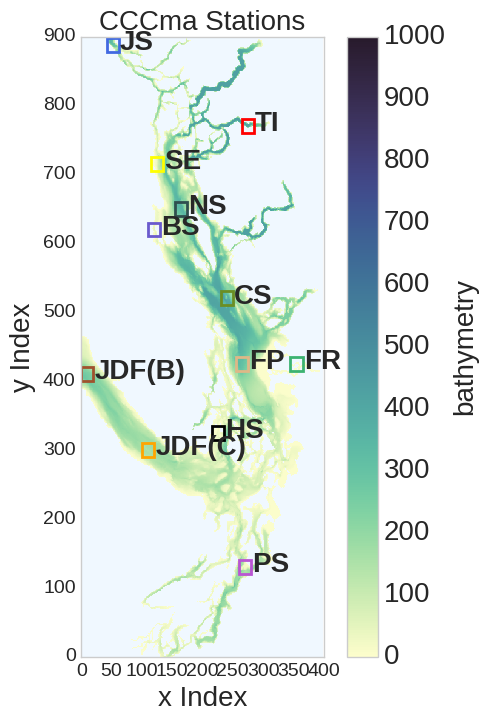

In [8]:
bath = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']

CCCma.one_panel_plot(bath1, cs.STATIONS, 'CCCma Stations', \
               cm.cm.deep,12*.5,16*.5,0,1000,'bathymetry','')

(1, 365)

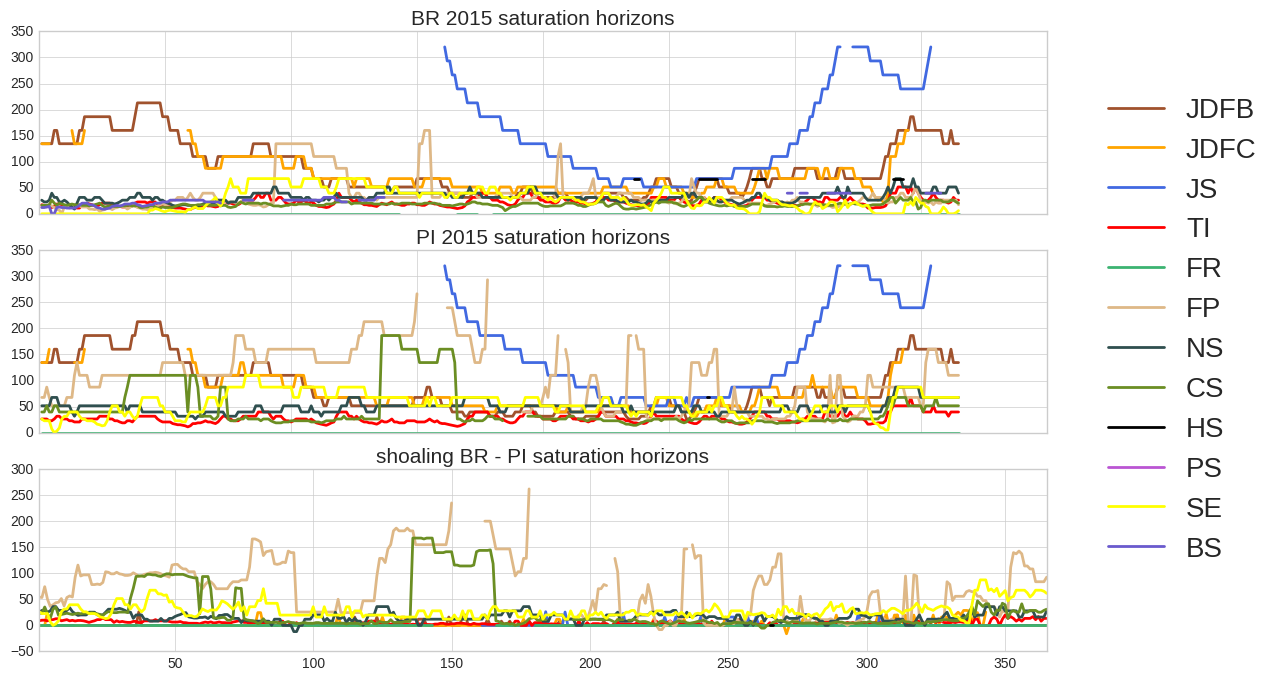

In [9]:
#['sal','temp','DIC','TA','OmA','pH','O2']


pt = ['sal_pt', 'temp_pt' , 'DIC_pt' , 'TA_pt' ,'OmA_pt' , 'pH_pt' , 'O2_pt' ]
sd = ['sal_sd', 'temp_sd' , 'DIC_sd' , 'TA_sd' ,'OmA_sd' , 'pH_sd' , 'O2_sd' ]
yl = ['salinity', 'temperature' , 'DIC' , 'TA' ,'Om A' , 'pH' , 'O2' ]
ymin = [0,0,0,0,0,7.2,0]
ymax = [35,25,2200,2200,3,8.6,320]
stns = ['JDFB','JDFC','JS','TI','FR','FP','NS','CS','HS','PS','SE','BS']
for c in range(0,len(cs.STATIONS)):
    stn = stns[c]
    #print(cs.STATIONS[stn]['color'])
    
t = np.arange(1,366,1)
fx = 13
fy = 8
fig = plt.figure(figsize=(fx,fy))


ax = fig.add_subplot(3,1,1)

for s in range(0,12):
    stn = stns[s]
    pattern = OmA_dict_BR['OmA_sathor'][s,:]    
    ax.plot(t, pattern, color = cs.STATIONS[stn]['color'],linewidth = 2 )
    ax.set_title('BR 2015 saturation horizons', fontsize = '15')
    ax.set_xticklabels([])
ax = fig.add_subplot(3,1,2)

for s in range(0,12):
    stn = stns[s]
    pattern = OmA_dict_PI['OmA_sathor'][s,:]    
    ax.plot(t, pattern, color = cs.STATIONS[stn]['color'],linewidth = 2 )
    ax.set_title('PI 2015 saturation horizons', fontsize = '15')
    ax.legend(stns , fontsize = 20, bbox_to_anchor=(1.05, 1.9), loc=2, borderaxespad=0.)
    ax.set_xticklabels([])
ax = fig.add_subplot(3,1,3)

for s in range(0,12):
    stn = stns[s]
    pattern = OmA_dict_PI['OmA_sathor'][s,:] - OmA_dict_BR['OmA_sathor'][s,:]
    ax.plot(t, pattern, color = cs.STATIONS[stn]['color'],linewidth = 2 )
    ax.set_title('shoaling BR - PI saturation horizons', fontsize = '15')

ax.set_xlim([1,365])

#plt.suptitle('2015 saturation horizons', fontsize = 30)

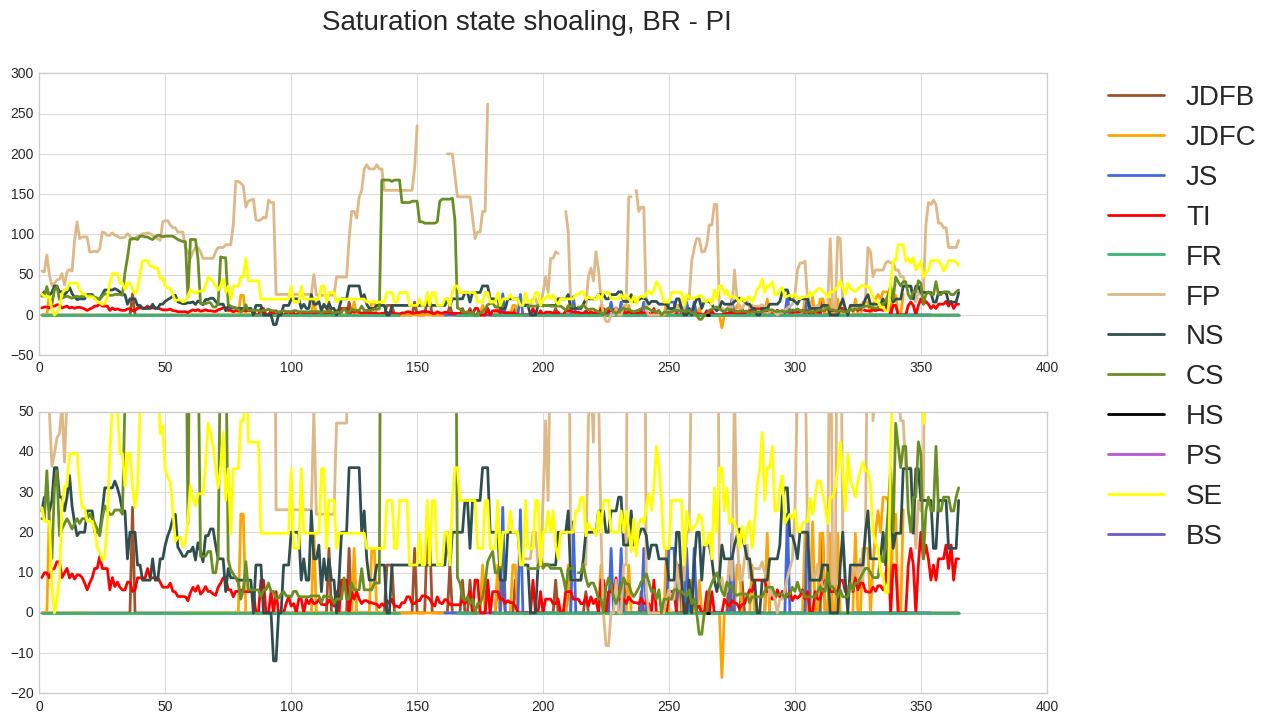

In [10]:
fx = 13
fy = 8
fig = plt.figure(figsize=(fx,fy))

ax = fig.add_subplot(2,1,1)

for s in range(0,12):
    stn = stns[s]
    pattern = OmA_dict_PI['OmA_sathor'][s,:] - OmA_dict_BR['OmA_sathor'][s,:]
    ax.plot(t, pattern, color = cs.STATIONS[stn]['color'],linewidth = 2 )
    ax.legend(stns , fontsize = 20, bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.)

ax = fig.add_subplot(2,1,2)

for s in range(0,12):
    stn = stns[s]
    pattern = OmA_dict_PI['OmA_sathor'][s,:] - OmA_dict_BR['OmA_sathor'][s,:]
    ax.plot(t, pattern, color = cs.STATIONS[stn]['color'],linewidth = 2 )
    ax.set_ylim([-20,50])
    
fig.suptitle('Saturation state shoaling, BR - PI', fontsize = 20)

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


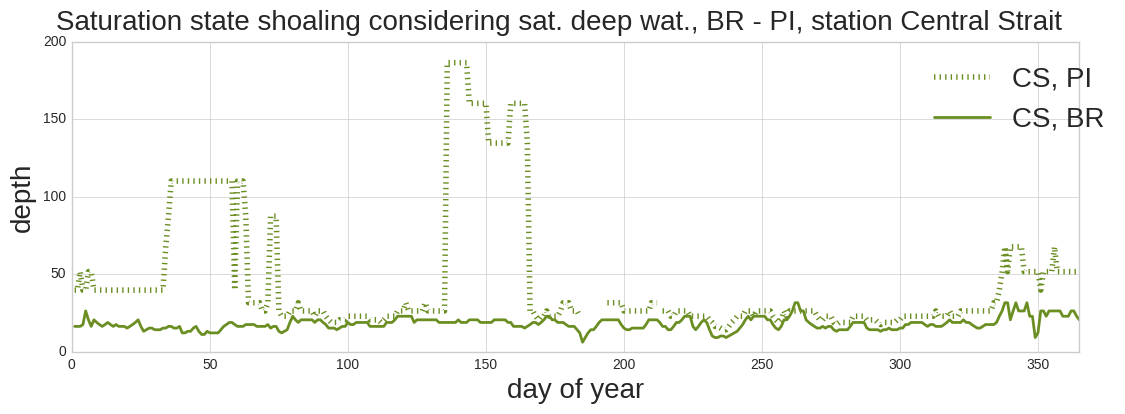

In [11]:
fx = 13
fy = 4
tstn = 'CS'
fig = plt.figure(figsize=(fx,fy))
ax = fig.add_subplot(1,1,1)

for s in range(0,12):
    stn = stns[s]
    patternBR = OmA_dict_BR['OmA_sathor'][s,:] 
    patternPI = OmA_dict_PI['OmA_sathor'][s,:]
    if stn == tstn:
        ax.plot(t, patternPI, color = cs.STATIONS[stn]['color'],linewidth = 4 , linestyle = ':', label = stn + ', PI')

        ax.plot(t, patternBR, color = cs.STATIONS[stn]['color'],linewidth = 2 , linestyle = '-', label = stn + ', BR')
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize = 20)
    ax.set_ylabel('depth', fontsize = 20)
    ax.set_xlabel('day of year', fontsize = 20)
    ax.set_xlim([0,365])
    ax.set_ylim([0,200])
fig.suptitle('Saturation state shoaling considering sat. deep wat., BR - PI, station '+ cs.STATIONS[tstn]['fullname'], fontsize = 20)

In [12]:
#code to retrieve profiles
dps = w['Profiles']['depth'][:]

OmA_prof_dict_BR = {'OmA' : np.zeros([12,40,365])}
OmA_prof_dict_PI = {'OmA' : np.zeros([12,40,365])}

for d in range(0,len(date_array)):
    td = date_array[d]
    BR = nc.Dataset(f'{tdir}/BR2015_{td}_prof.nc')
    saBR = BR['Profiles']['OmA_prof'][:]
    OmA_prof_dict_BR['OmA'][0:12,0:40,d] = saBR[:]
    PI = nc.Dataset(f'{tdir}/PI2015_{td}_prof.nc')
    saPI = PI['Profiles']['OmA_prof'][:]
    OmA_prof_dict_PI['OmA'][0:12,0:40,d] = saPI[:]
    
    


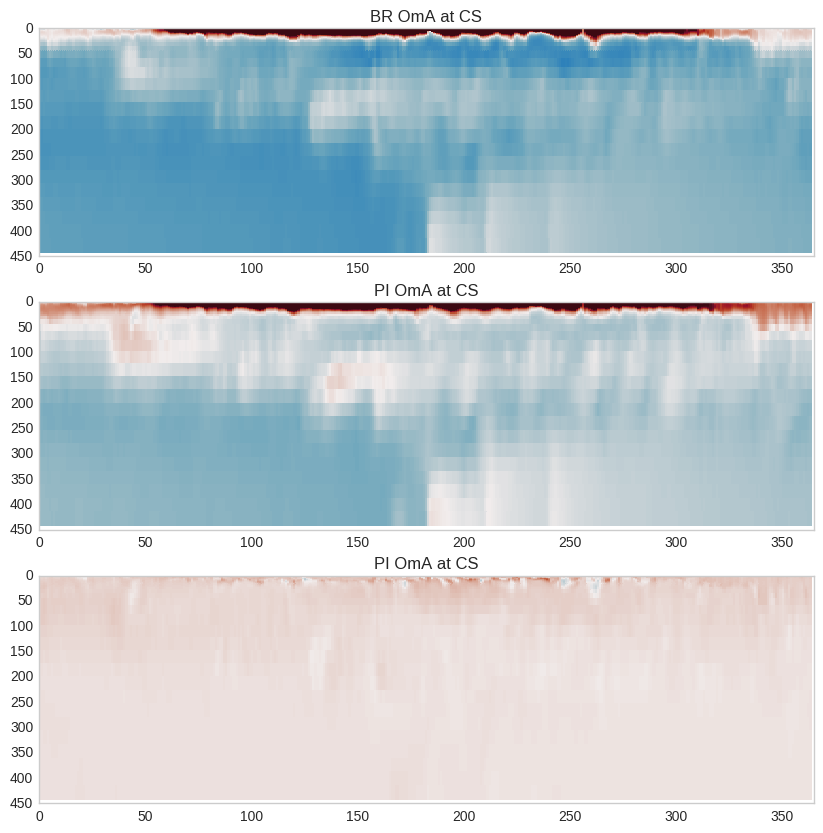

In [13]:
zlevels = PI['Profiles']['depth'][:]
fig = plt.figure(figsize=(10,10))

for i in range(1,4):
    ax = fig.add_subplot(3,1,i)
    dst = 0 
    den = 365
    section_slice = np.arange(dst, den)
    if i == 1:
        ax.invert_yaxis()
        tplt = OmA_prof_dict_BR['OmA'][7,0:40,dst:den][:]
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=0.5, vmax=1.5 )
        ax.set_title('BR OmA at CS')
        ax.set_xlim([0,365])
    if i == 2:
        ax.invert_yaxis()
        tplt = OmA_prof_dict_PI['OmA'][7,0:40,dst:den][:]
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=0.5, vmax=1.5 )
        ax.set_title('PI OmA at CS')
        ax.set_xlim([0,365])
    if i == 3:
        ax.invert_yaxis()
        tplt = OmA_prof_dict_PI['OmA'][7,0:40,dst:den][:] - OmA_prof_dict_BR['OmA'][7,0:40,dst:den][:] 
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-1.5, vmax=1.5 )
        ax.set_title('PI OmA at CS')
        ax.set_xlim([0,365])

/home/tjarniko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal
/home/tjarniko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less
/home/tjarniko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater_equal
/home/tjarniko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in less


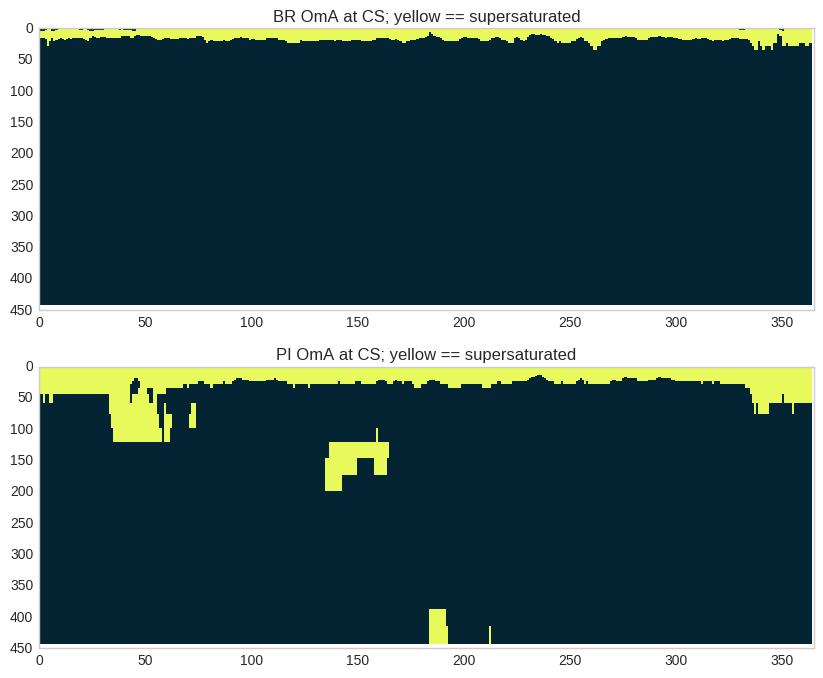

In [14]:
zlevels = PI['Profiles']['depth'][:]
fig = plt.figure(figsize=(10,8))

for i in range(1,3):
    ax = fig.add_subplot(2,1,i)
    dst = 0 
    den = 365
    section_slice = np.arange(dst, den)
    if i == 1:
        ax.invert_yaxis()
        tplt = OmA_prof_dict_BR['OmA'][7,0:40,dst:den][:]
        tplt[tplt>=1] = 1
        tplt[tplt<1] = -1
        tcmap = cm.cm.thermal
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-1, vmax=1  )
        ax.set_title('BR OmA at CS; yellow == supersaturated')
        ax.set_xlim([0,365])
    if i == 2:
        ax.invert_yaxis()
        tplt = OmA_prof_dict_PI['OmA'][7,0:40,dst:den][:]
        tplt[tplt>=1] = 1
        tplt[tplt<1] = -1
        tcmap = cm.cm.thermal
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-1, vmax=1 )
        ax.set_title('PI OmA at CS; yellow == supersaturated')
        ax.set_xlim([0,365])


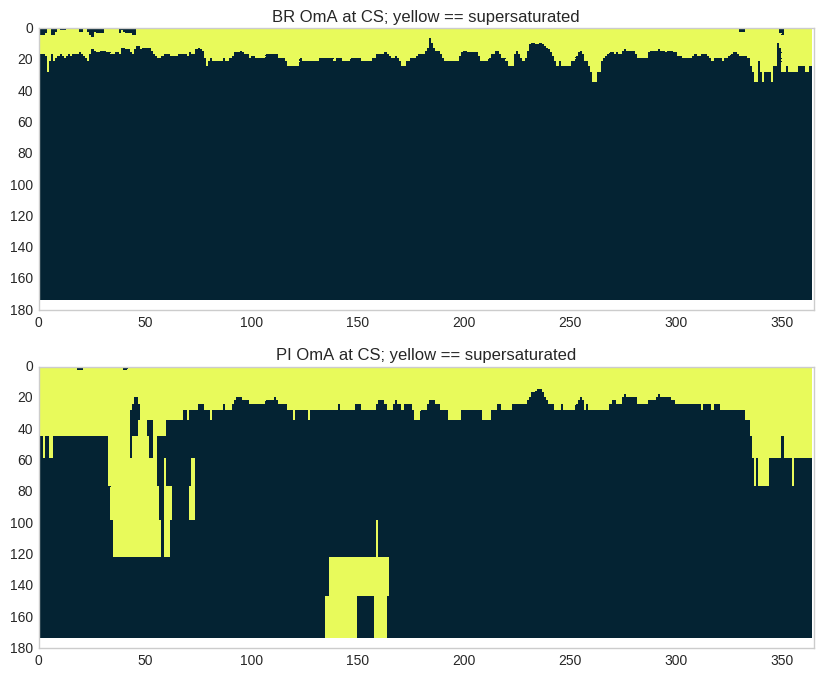

In [15]:
dp = 30 
zlevels = PI['Profiles']['depth'][0:dp]
fig = plt.figure(figsize=(10,8))

for i in range(1,3):
    ax = fig.add_subplot(2,1,i)
    dst = 0 
    den = 365
    section_slice = np.arange(dst, den)
    if i == 1:
        ax.invert_yaxis()
        tplt = OmA_prof_dict_BR['OmA'][7,0:dp,dst:den][:]
        tplt[tplt>=1] = 1
        tplt[tplt<1] = -1
        tcmap = cm.cm.thermal
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-1, vmax=1  )
        ax.set_title('BR OmA at CS; yellow == supersaturated')
        ax.set_xlim([0,365])
    if i == 2:
        ax.invert_yaxis()
        tplt = OmA_prof_dict_PI['OmA'][7,0:dp,dst:den][:]
        tplt[tplt>=1] = 1
        tplt[tplt<1] = -1
        tcmap = cm.cm.thermal
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-1, vmax=1 )
        ax.set_title('PI OmA at CS; yellow == supersaturated')
        ax.set_xlim([0,365])


/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


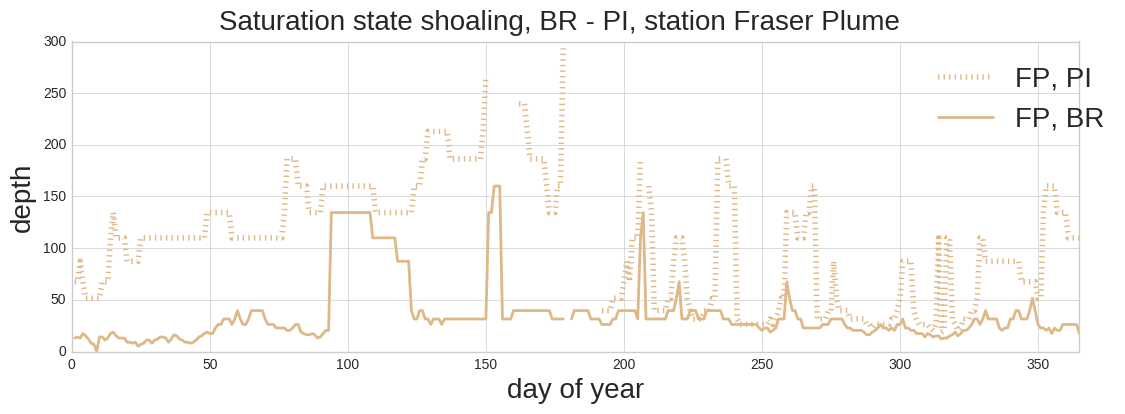

In [16]:
fx = 13
fy = 4
tstn = 'FP'
fig = plt.figure(figsize=(fx,fy))
ax = fig.add_subplot(1,1,1)

for s in range(0,12):
    stn = stns[s]
    patternBR = OmA_dict_BR['OmA_sathor'][s,:] 
    patternPI = OmA_dict_PI['OmA_sathor'][s,:]
    if stn == tstn:
        ax.plot(t, patternPI, color = cs.STATIONS[stn]['color'],linewidth = 4 , linestyle = ':', label = stn + ', PI')

        ax.plot(t, patternBR, color = cs.STATIONS[stn]['color'],linewidth = 2 , linestyle = '-', label = stn + ', BR')
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize = 20)
    ax.set_ylabel('depth', fontsize = 20)
    ax.set_xlabel('day of year', fontsize = 20)
    ax.set_xlim([0,365])
fig.suptitle('Saturation state shoaling, BR - PI, station '+ cs.STATIONS[tstn]['fullname'], fontsize = 20)

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


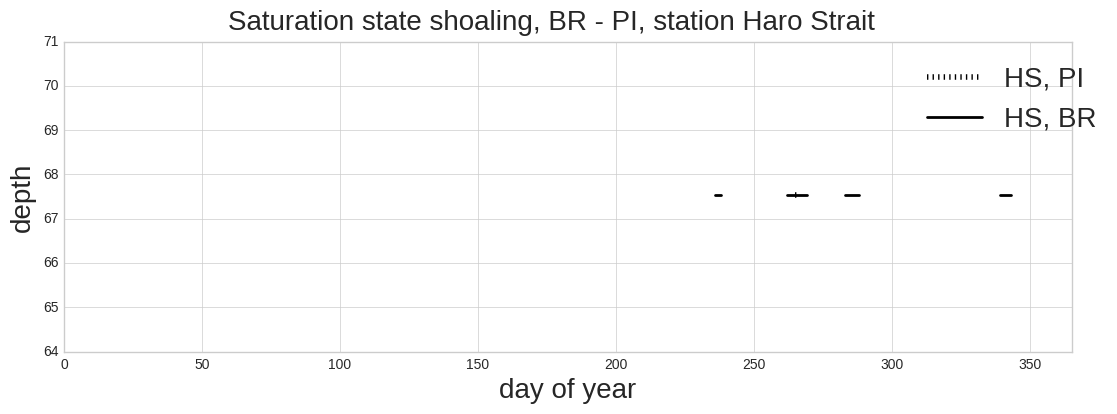

In [17]:
fx = 13
fy = 4
tstn = 'HS'
fig = plt.figure(figsize=(fx,fy))
ax = fig.add_subplot(1,1,1)

for s in range(0,12):
    stn = stns[s]
    patternBR = OmA_dict_BR['OmA_sathor'][s,:] 
    patternPI = OmA_dict_PI['OmA_sathor'][s,:]
    if stn == tstn:
        ax.plot(t, patternPI, color = cs.STATIONS[stn]['color'],linewidth = 4 , linestyle = ':', label = stn + ', PI')

        ax.plot(t, patternBR, color = cs.STATIONS[stn]['color'],linewidth = 2 , linestyle = '-', label = stn + ', BR')
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize = 20)
    ax.set_ylabel('depth', fontsize = 20)
    ax.set_xlabel('day of year', fontsize = 20)
    ax.set_xlim([0,365])
fig.suptitle('Saturation state shoaling, BR - PI, station '+ cs.STATIONS[tstn]['fullname'], fontsize = 20)

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


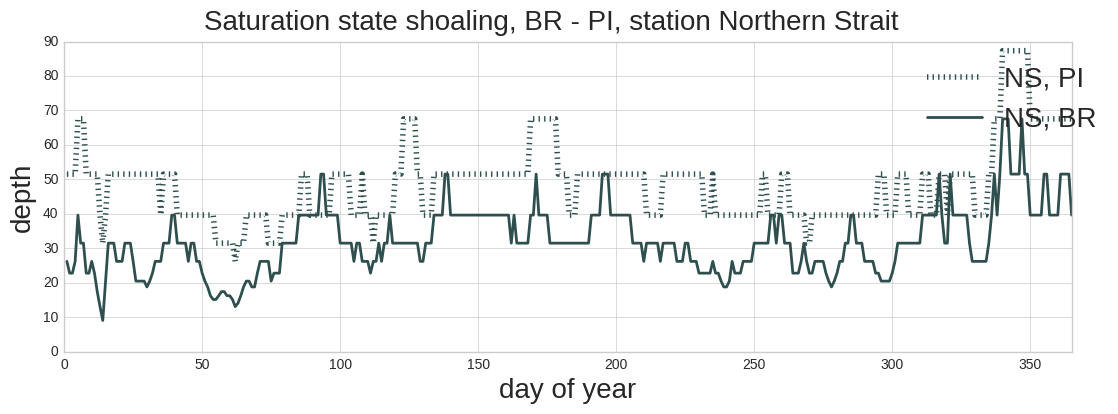

In [18]:
fx = 13
fy = 4
tstn = 'NS'
fig = plt.figure(figsize=(fx,fy))
ax = fig.add_subplot(1,1,1)

for s in range(0,12):
    stn = stns[s]
    patternBR = OmA_dict_BR['OmA_sathor'][s,:] 
    patternPI = OmA_dict_PI['OmA_sathor'][s,:]
    if stn == tstn:
        ax.plot(t, patternPI, color = cs.STATIONS[stn]['color'],linewidth = 4 , linestyle = ':', label = stn + ', PI')

        ax.plot(t, patternBR, color = cs.STATIONS[stn]['color'],linewidth = 2 , linestyle = '-', label = stn + ', BR')
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize = 20)
    ax.set_ylabel('depth', fontsize = 20)
    ax.set_xlabel('day of year', fontsize = 20)
    ax.set_xlim([0,365])
fig.suptitle('Saturation state shoaling, BR - PI, station '+ cs.STATIONS[tstn]['fullname'], fontsize = 20)

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


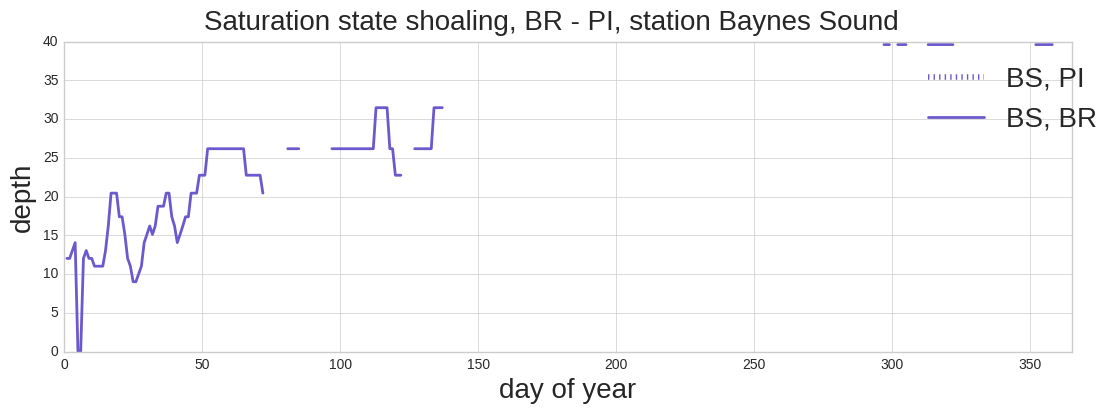

In [19]:
fx = 13
fy = 4
tstn = 'BS'
fig = plt.figure(figsize=(fx,fy))
ax = fig.add_subplot(1,1,1)

for s in range(0,12):
    stn = stns[s]
    patternBR = OmA_dict_BR['OmA_sathor'][s,:] 
    patternPI = OmA_dict_PI['OmA_sathor'][s,:]
    if stn == tstn:
        ax.plot(t, patternPI, color = cs.STATIONS[stn]['color'],linewidth = 4 , linestyle = ':', label = stn + ', PI')

        ax.plot(t, patternBR, color = cs.STATIONS[stn]['color'],linewidth = 2 , linestyle = '-', label = stn + ', BR')
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize = 20)
    ax.set_ylabel('depth', fontsize = 20)
    ax.set_xlabel('day of year', fontsize = 20)
    ax.set_xlim([0,365])
fig.suptitle('Saturation state shoaling, BR - PI, station '+ cs.STATIONS[tstn]['fullname'], fontsize = 20)

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


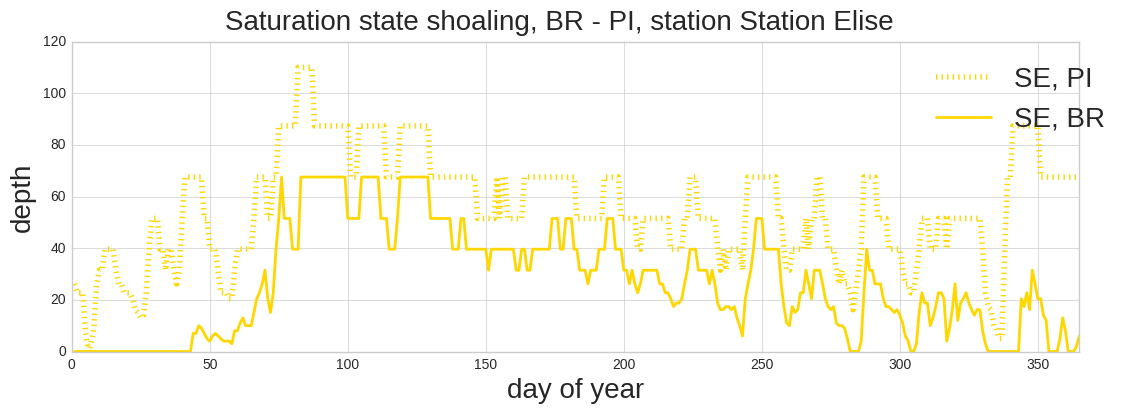

In [20]:
fx = 13
fy = 4
tstn = 'SE'
fig = plt.figure(figsize=(fx,fy))
ax = fig.add_subplot(1,1,1)

for s in range(0,12):
    stn = stns[s]
    patternBR = OmA_dict_BR['OmA_sathor'][s,:] 
    patternPI = OmA_dict_PI['OmA_sathor'][s,:]
    if stn == tstn:
        ax.plot(t, patternPI, color = 'gold',linewidth = 4 , linestyle = ':', label = stn + ', PI')

        ax.plot(t, patternBR, color = 'gold',linewidth = 2 , linestyle = '-', label = stn + ', BR')
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize = 20)
    ax.set_ylabel('depth', fontsize = 20)
    ax.set_xlabel('day of year', fontsize = 20)
    ax.set_xlim([0,365])
fig.suptitle('Saturation state shoaling, BR - PI, station '+ cs.STATIONS[tstn]['fullname'], fontsize = 20)